# CS M152A MNIST CLASSIFIER

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, autograd
import torch.nn.init
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

# Data normalization transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load MNIST
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [2]:
class MNIST_compressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, 4, stride = 4)
        self.conv1.weight.data.fill_(1/16)
        self.conv1.bias.data.fill_(0)
    def forward(self, x):
        m = nn.ConstantPad2d(2, -1)
        x = self.conv1(m(x))
        return x

In [3]:
n_hidden = 100
n_output = 10
n_input = 64
classifier = nn.Sequential(nn.Linear(n_input, n_hidden),
                           nn.ReLU(),
                           nn.Linear(n_hidden, n_output),
                           nn.LogSoftmax(dim=1))

In [4]:
mnist_compression = MNIST_compressor()
criterion = nn.CrossEntropyLoss()
epochs = 5
optimizer = optim.Adam(classifier.parameters(), lr=0.003)
t = torch.Tensor([-0.5])
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = mnist_compression(images).detach()
        images = images.view(images.shape[0], -1)
        images = (images > t).float()
        optimizer.zero_grad()
        output = classifier(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.7043219628745813
Training loss: 0.4779470110975349
Training loss: 0.4308671415296953
Training loss: 0.40998201258083394
Training loss: 0.3964635702147921


In [5]:
# %matplotlib inline

# imagenum = 8
# images, labels = next(iter(trainloader))

# images = mnist_compression(images).detach()
# images = images.view(images.shape[0], -1)
# images = (images > t).float()
# img = images[imagenum].view(1, 64)
# print(labels[imagenum])

# # Turn off gradients to speed up this part
# with torch.no_grad():
#     logps = classifier(img)

# # Output of the network are log-probabilities, need to take exponential for probabilities
# ps = torch.exp(logps)
# plt.imshow(img.view(1, 8, 8).numpy().squeeze())
# print(ps)

classifier2 = nn.Sequential(nn.Linear(n_input, n_hidden),
                            nn.ReLU(),
                            nn.Linear(n_hidden, n_output))
classifier2[0].weight.data = torch.round(classifier[0].weight*100)
classifier2[2].weight.data = torch.round(classifier[2].weight*100)
classifier2[0].bias.data = torch.round(classifier[0].bias * 100)
classifier2[2].bias.data = torch.round(classifier[2].bias * 100)

tensor(1)
tensor([1])


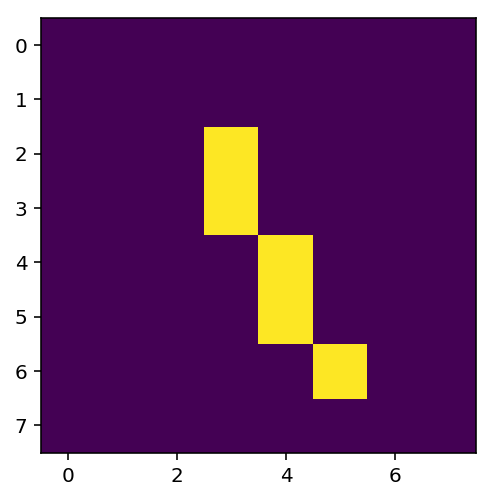

In [6]:
%matplotlib inline

imagenum = 8
images, labels = next(iter(trainloader))

images = mnist_compression(images).detach()
images = images.view(images.shape[0], -1)
images = (images > t).float()
img = images[imagenum].view(1, 64)
print(labels[imagenum])

# Turn off gradients to speed up this part
with torch.no_grad():
    activations = classifier2(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
values, indices = torch.max(activations, 1)
print(indices)
plt.imshow(img.view(1, 8, 8).numpy().squeeze())

In [7]:
np.savetxt('input2hidden', classifier2[0].weight.data.numpy().astype(int), fmt='%-1.2i',delimiter='\n', newline='\n')
np.savetxt('hidden2output', classifier2[2].weight.data.numpy().astype(int), fmt='%-1.2i',delimiter='\n', newline='\n')

In [8]:
np.savetxt('input2hidden_bias', classifier2[0].bias.data.numpy().astype(int), fmt='%-1.2i', delimiter='\n', newline='\n')
np.savetxt('hidden2output_bias', classifier2[2].bias.data.numpy().astype(int), fmt='%-1.2i', delimiter='\n', newline='\n')

In [12]:
from bitstring import Bits


def convert_to_9bit_2s_complement(filename, line_length):
    input = open(filename, 'r')
    output = open(filename + '_b', 'w')
    i = 0
    for line in input:
        if(i >= line_length):
            output.write('\n')
            i=0
        output.write(str(Bits(int=int(line), length=9).bin))
        i+= 1

            

In [13]:
convert_to_9bit_2s_complement('hidden2output_bias', 1)
convert_to_9bit_2s_complement('input2hidden_bias', 1)
convert_to_9bit_2s_complement('input2hidden', 64)
convert_to_9bit_2s_complement('hidden2output', 100)